In [17]:
import numpy as np
import pandas as pd
import sys, copy
import matplotlib.pyplot as plt
import pylab as matlib
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB
from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'

#https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot, dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

Information about template changes at MJDs 58417 and 58882: https://fallingstar-data.com/forcedphot/faq/

<strong>Procedure</strong>

Step A: Does a correlation exist between the "good"/"bad" classification of a SN and the PSF chi square distribution of its bad measurements?
1. Obtain SNe with a high uJy/duJy, of which half are "good" and half are "bad."
    - Estimate rough brightness of each SN by getting 90th percentile flux and determine if SN is a good candidate.
    - To confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%. 
2. For each SN, take the measurements for which abs(uJy/duJy)>3. Then plot a histogram of only those measurements' PSF chi squares on a logarithmic scale. Do the same for abs(uJy/duJy)<=3, and compare to the ones with abs(uJy/duJy)>3.
3. Combine the histograms of each SN and colorcode them. 
4. See if each SN's classification is predicted by its chi square distribution on the histogram. 

Step B: Does a correlation exist between the "good"/"bad" classification of a SN and its x2PSF vs. S/N plot?
1. For both samples of "good" and "bad" SNe, plot their PSF chi squares vs. uJy/duJy. 
2. See if each SN's classification is predicted by the shape of its graph ("shallow" or "hockey stick").

In [ ]:
# Obtain 2 or 4 preliminary SNe with a high uJy/duJy, of which half are "good" and half are "bad."

lc_dict = {}

lc_info = pdastrostatsclass()
lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo','2017gjn','2017glq','2017gup','2017guu','2017guv','2017haf','2017gqr','2017guh','2017gvp','2017ghu','2017hgz','2017hjw','2017hjy','2017hoq','2017hpa','2017hou','2017igf','2017isq','2017gxq','2017isj','2017iyb','2017iji','2017jav','2017iyw','2017jyl','2018cqw','2020ejm','2017izu','2019syd','2017gjd','2018jaj','2018jov','2018jaz','2018jaz','2018imd','2018kfv','2017jd','2018pc','2020fcw','2018hkq','2019wdx','2018lqy','2018gfi','2018K','2020dkm','2018yh','2020afp','2019wrz','2018gv','2018iq','2018gl','2018kp','2018oh','2018pv','2018xx','2018yu','2018aaz','2018zz','2018ajp','2018aqh','2018aoz','2018aqi','2018azu','2018aye','2018cnj','2018cqj','2018cuw','2018dda','2018dzy','2018ebk','2018ddi','2018enc','2018epx','2018etm','2018feb','2018fop','2018fli','2018fnq','2018fhx']
lc_info.t['mjdstart'] = [58955.26,58768.04,58925.20,57994.85992,57999.35754,58013.556,58009.58899,58011.305,58026.5,58005.1567,58014.31,58019.48,57991.4866,58036.02,58040.57399,58040.49699,58047.551,58051.34602,58050.37014,58075.59,58091.618,58013.453,58089.34568,58103.44699,58077.64,58106.24301,58105.3,58117.546,58287.2,58919.23791,58101.97699,58767.10699,57994.09,58447.48199,58460.583,58442.51023,58442.51023,58436.8626,58468.28699,57762.21399,58152.75,58936.437,58406.37,58824.38,58358.39,58373.4,58121.13589,58904.44051,58173.25,58866.66,58832.48,58133.68132,58137.49453,58131.56999,58142.36257,58153.49,58152.63133,58170.38199,58178.223,58183.56689,58180.92,58195.81,58213.44899,58210.30899,58214.07,58220.28699,58229.31,58266.61199,58282.268,58293.515,58303.96,58315.59399,58315.55199,58301.44,58332.32699,58335.605,58338.343,58346.16399,58351.56899,58343.15199,58361.08,58351.38]
lc_info.t['classification'] = ['good','bad','good',None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
#lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo','2018pv','2017guh','2018oh']
#lc_info.t['mjdstart'] = [59005.264,58818.04,58975.20256,58152.631331,58014.31,58153.49]
#lc_info.t['classification'] = ['good','bad',None,None,None,None]
lc_info.t['lc_dict key'] = [None] * len(lc_info.t)

def load_lc_dict(lc_dict, lc_info):
    for index in range(0,len(lc_info.t)):
        lc_info.t.loc[index,'lc_dict key'] = index
        lc_dict[index] = pdastrostatsclass()
        dir = '/Users/sofiarest/OneDrive - Johns Hopkins/Freshman Year/researchpaper/atlaslc_chisquare/'
        filename = dir+'brightsne/'+lc_info.t.loc[index,'tnsname']+'/'+lc_info.t.loc[index,'tnsname']+'_i000.o.lc.txt'
        print('Loading SN '+lc_info.t.loc[index,'tnsname']+' at '+filename+'...')
        lc_dict[index].load_spacesep(filename,delim_whitespace=True)
        lc_dict[index].t['uJy/duJy'] = lc_dict[index].t['uJy']/lc_dict[index].t['duJy']
    return lc_dict, lc_info

def plot_lc(lc,info):
    plt.figure()
    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    aftersn = np.where(lc.t['MJD'] > info['mjdstart'])[0]

    sp, plot_baseline, dplot = dataPlot(lc.t.loc[baseline,'MJD'],lc.t.loc[baseline,'uJy'])
    matlib.setp(plot_baseline,ms=5,color='b',marker='o')
    sp, plot_aftersn, dplot = dataPlot(lc.t.loc[aftersn,'MJD'],lc.t.loc[aftersn,'uJy'])
    matlib.setp(plot_aftersn,ms=5,color='c',marker='o')

    plt.axhline(linewidth=1,color='k')
    plt.ylabel('uJy')
    plt.xlabel('MJD')
    plt.title('SN '+info['tnsname']+' Light Cuve')

    plt.axvline(x=58882,color='magenta')
    plt.axvline(x=58417,color='magenta')

lc_dict, lc_info = load_lc_dict(lc_dict, lc_info)
print(lc_info.t)

for index in range(0,len(lc_info.t)):
    plot_lc(lc_dict[index],lc_info.t.loc[index])

In [ ]:
# Estimate rough brightness of each SN by getting 90th percentile flux from mjdstart to mjdstart+60 and determine if SN is a good candidate.

def get_90th_percentile_flux(lc, info):
    target = AandB(np.where(lc.t['MJD']>info['mjdstart'])[0], np.where(lc.t['MJD']<info['mjdstart']+60)[0])
    if len(target)==0: 
        return None
    else:
        return np.percentile(lc.t.loc[target, 'uJy'], 90)

def remove_SN(lc_info,index):
    print('Removing SN at index %d...' % index)
    lc_info.t = lc_info.t.drop([index])
    lc_info.t = lc_info.t.reset_index(drop=True)
    return lc_info

def get_90th_percentile_flux_loop(lc_dict, lc_info):
    index = 0
    while index < len(lc_info.t):
        flux = get_90th_percentile_flux(lc_dict[lc_info.t.loc[index,'lc_dict key']], lc_info.t.loc[index])
        if flux is None:
            print('WARNING: For %s, 90th percentile flux not found' % (lc_info.t.loc[index,'tnsname']))
            lc_info = remove_SN(lc_info,index)
        elif(flux > 1000):
            print('For %s, 90th percentile flux %0.2f is over 1000 ' % (lc_info.t.loc[index,'tnsname'], flux) + u'\u2713')
            index += 1
        else:
            print('WARNING: For %s, 90th percentile flux %0.2f is under 1000' % (lc_info.t.loc[index,'tnsname'], flux))
            lc_info = remove_SN(lc_info,index)
    return lc_dict, lc_info

lc_dict, lc_info = get_90th_percentile_flux_loop(lc_dict, lc_info)
print('\nRevised sample of SNe (only SNe with high flux): \n',lc_info.t)

# To confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%. 

stdev_limit = 1.5
nclippercent_limit = 5.0
print('\nstdev limit: %0.1f, %% data clipped limit: %0.1f' % (stdev_limit, nclippercent_limit))

def sigmacut_lc_dicts(lc, info):
    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    lc.calcaverage_sigmacutloop('uJy/duJy',noisecol=None,indices=baseline,verbose=1,Nsigma=3.0,median_firstiteration=True)
    print('stdev: ',lc.statparams['stdev'],', % data clipped: ',100*lc.statparams['Nclip']/len(lc.t))

    output = 'Classified as '
    if lc.statparams['stdev'] is None or lc.statparams['Nclip'] is None:
        classification = 'bad'
    elif(lc.statparams['stdev']<stdev_limit and (100*lc.statparams['Nclip']/len(lc.t))<nclippercent_limit):
        classification = 'good'
    else: 
        classification = 'bad'
    output += classification + ' SN; '
    if(info['classification']==classification):
        output += 'consistent with preliminary classification ' + u'\u2713'
    else:
        output += 'WARNING: not consistent with preliminary classification (\'%s\')\nReclassifying in table...' % info['classification']
        info['classification'] = classification
    print(output)

    return info

for index in range(0, len(lc_info.t)):
    print('\nSigmacutting %s...' % lc_info.t.loc[index,'tnsname'])
    lc_info.t.loc[index] = sigmacut_lc_dicts(lc_dict[lc_info.t.loc[index,'lc_dict key']], lc_info.t.loc[index])
print('\nRevised sample of bright SNe (all SNe reclassified as good or bad): \n',lc_info.t)

lc_info_good = lc_info.t.loc[np.where(lc_info.t['classification']=='good')[0]]
lc_info_bad = lc_info.t.loc[np.where(lc_info.t['classification']=='bad')[0]]

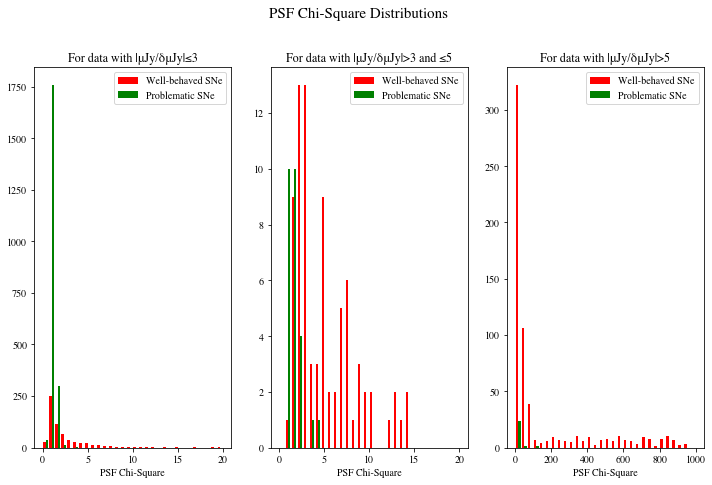

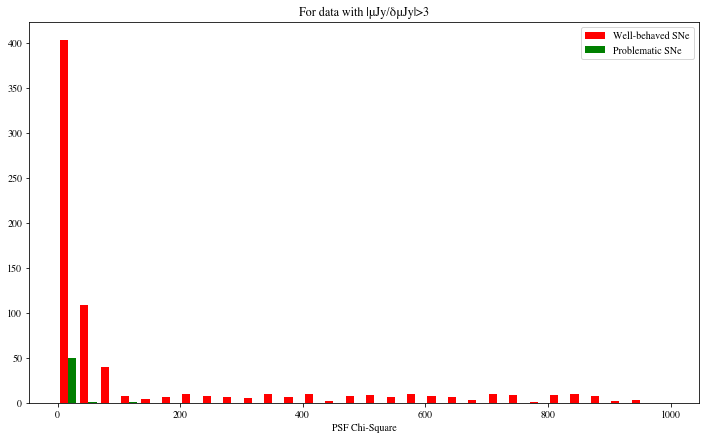

In [51]:
# For each SN, take the measurements for which abs(uJy/duJy)>3 and for which abs(uJy/duJy)<=3.
# Then plot two histograms of those measurements' PSF chi squares on a logarithmic scale. 
# Combine the histograms of each SN and colorcode them. 
# See if each SN's classification is predicted by its chi square distribution on the histograms. 

def get_chisquare_data(lc_dict,lc_info):
    lc_info = lc_info.reset_index(drop=True)

    # 3 dfs to store all chi squares corresponding to their uJy/duJy ranges
    leq3_df = pd.Series()
    gr3l5_df = pd.Series()
    gr5_df = pd.Series()

    # for each SN
    for index in range(0,len(lc_info)):
        baseline = np.where(lc_dict[lc_info.loc[index,'lc_dict key']].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]

        leq3 = np.where(abs(lc_dict[lc_info.loc[index,'lc_dict key']].t['uJy/duJy']) <= 3)[0]
        gr3l5 = AandB(np.where(abs(lc_dict[lc_info.loc[index,'lc_dict key']].t['uJy/duJy']) > 3)[0], np.where(abs(lc_dict[lc_info.loc[index,'lc_dict key']].t['uJy/duJy']) <= 5)[0])
        gr5 = np.where(abs(lc_dict[lc_info.loc[index,'lc_dict key']].t['uJy/duJy']) > 5)[0]

        # add chi squares to their corresponding dfs
        leq3_df = pd.concat([leq3_df, lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[AandB(leq3,baseline),'chi/N']], ignore_index=True)
        gr3l5_df = pd.concat([gr3l5_df, lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[AandB(gr3l5,baseline),'chi/N']], ignore_index=True)
        gr5_df = pd.concat([gr5_df, lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[AandB(gr5,baseline),'chi/N']], ignore_index=True)
    
    return leq3_df, gr3l5_df, gr5_df

def plot_chisquare_data(chisquare_data):
    fig, axes = plt.subplots(nrows=1, ncols=3)
    plt.suptitle('PSF Chi-Square Distributions',fontsize=15, y=1)
    leq3_hist, gr3l5_hist, gr5_hist = axes.flatten()

    leq3_hist.hist([chisquare_data['b_leq3_df'],chisquare_data['g_leq3_df']],bins=30,range=(0,20),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
    leq3_hist.set_title("For data with |μJy/δμJy|≤3")
    leq3_hist.set_xlabel("PSF Chi-Square")
    leq3_hist.legend()

    gr3l5_hist.hist([chisquare_data['b_gr3l5_df'],chisquare_data['g_gr3l5_df']],bins=30,range=(0,20),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
    gr3l5_hist.set_title("For data with |μJy/δμJy|>3 and ≤5")
    gr3l5_hist.set_xlabel("PSF Chi-Square")
    gr3l5_hist.legend()

    gr5_hist.hist([chisquare_data['b_gr5_df'],chisquare_data['g_gr5_df']],bins=30,range=(0,1000),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
    gr5_hist.set_title("For data with |μJy/δμJy|>5")
    gr5_hist.set_xlabel("PSF Chi-Square")
    gr5_hist.legend()

    plt.savefig('chisquare_histogram.png', dpi=200)

    b_gr3_df = pd.concat([chisquare_data['b_gr3l5_df'],chisquare_data['b_gr5_df']],ignore_index=True)
    g_gr3_df = pd.concat([chisquare_data['g_gr3l5_df'],chisquare_data['g_gr5_df']],ignore_index=True)
    plt.figure()
    plt.hist([b_gr3_df,g_gr3_df],bins=30,range=(0,1000),color=['r','g'], label=['Well-behaved SNe','Problematic SNe'])
    plt.title("For data with |μJy/δμJy|>3")
    plt.xlabel("PSF Chi-Square")
    plt.legend()

chisquare_data = {}

chisquare_data['g_leq3_df'], chisquare_data['g_gr3l5_df'], chisquare_data['g_gr5_df'] = get_chisquare_data(lc_dict, lc_info_good)
chisquare_data['b_leq3_df'], chisquare_data['b_gr3l5_df'], chisquare_data['b_gr5_df'] = get_chisquare_data(lc_dict, lc_info_bad)

plot_chisquare_data(chisquare_data)

In [ ]:
# For both samples of "good" and "bad" SNe, plot their PSF chi squares vs. uJy/duJy. 
# See if each SN's classification is predicted by the shape of its graph ("shallow" or "hockey stick").

"""def plot_data(lc_dict, lc_info):
    plt.figure()
    lc_info = lc_info.reset_index(drop=True)
    for index in range(0, len(lc_dict)):
        baseline = np.where(lc_dict[index].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        sp, plot, dplot = dataPlot(lc_dict[index].t.loc[baseline,'uJy/duJy'],lc_dict[index].t.loc[baseline,'chi/N'])
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.ylabel('PSF Chi Square')
    plt.xlabel('uJy/duJy')
    return sp, plot, dplot

sp, plot1, dplot = plot_data(good_lc,lc_info_good)
matlib.setp(plot1,ms=5,color='g',marker='o')
plt.title('PSF Chi Square vs. S/N for Good SNe')
plt.xlim(-5,5)
plt.ylim(-1,3)

sp, plot2, dplot = plot_data(bad_lc,lc_info_bad)
matlib.setp(plot2,ms=5,color='r',marker='o')
plt.title('PSF Chi Square vs. S/N for Bad SNe')
plt.xlim(-20,400)
plt.ylim(-100,6000)"""

def plot_chisquare_stn_loop(lc_dict, lc_info):
    plt.figure()
    lc_info = lc_info.reset_index(drop=True)
    for index in range(0, len(lc_info)):
        baseline = np.where(lc_dict[lc_info.loc[index,'lc_dict key']].t['MJD'] < lc_info.loc[index,'mjdstart'])[0]
        after_mjdstart = np.where(lc_dict[lc_info.loc[index,'lc_dict key']].t['MJD'] > lc_info.loc[index,'mjdstart'])[0]
        sp, plot1, dplot = dataPlot(lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[baseline,'uJy/duJy'],lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[baseline,'chi/N'])
        matlib.setp(plot1,ms=5,color='b',marker='o')
        sp, plot2, dplot = dataPlot(lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[after_mjdstart,'uJy/duJy'],lc_dict[lc_info.loc[index,'lc_dict key']].t.loc[after_mjdstart,'chi/N'])
        matlib.setp(plot2,ms=5,color='c',marker='o')
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.ylabel('PSF Chi Square')
    plt.xlabel('uJy/duJy')

plot_chisquare_stn_loop(lc_dict,lc_info_bad)
plt.title('PSF Chi Square vs. S/N for Bad SNe')
plt.xlim(-20,150)
plt.ylim(-10,50)

plot_chisquare_stn_loop(lc_dict,lc_info_good)
plt.title('PSF Chi Square vs. S/N for Good SNe')

In [ ]:
def plot_stn_chisquare(lc, info):
    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    plt.figure()
    sp, plot, dplot = dataPlot(lc.t.loc[baseline,'chi/N'],lc.t.loc[baseline,'uJy/duJy'])
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    plt.xlabel('PSF Chi Square')
    plt.ylabel('uJy/duJy')
    if info['classification']=='good':
        color = 'g'
    else:
        color = 'r'
    matlib.setp(plot,ms=5,color=color,marker='o')
    plt.title('S/N vs. PSF Chi Square for SN ' + info['tnsname'])

def plot_stn_chisquare_loop(lc_dict, lc_info):
    lc_info.t = lc_info.t.reset_index(drop=True)
    for index in range(0, len(lc_info.t)):
        plot_stn_chisquare(lc_dict[lc_info.t.loc[index,'lc_dict key']],lc_info.t.loc[index])

plot_stn_chisquare_loop(lc_dict,lc_info)


In [ ]:
"""
1. static cut at x2=50; get percent cut before and after mjdstart
2. for different x2 cuts decreasing from 50 and cut at abs(s/n)=3 (or 5?):
    a. for baseline: calculate each quadrant's percent
    b. for both baseline and  SN: calculate each half's percent 
"""

global cut_start
global cut_stop
global cut_step
cut_start = 2
cut_stop = 50 # this is inclusive
cut_step = 2

global sn_cut
sn_cut = 3 # abs(uJy/duJy) cut

def plot_table(table,info,lim1,lim2):
    plt.figure()
    plt.title('SN '+info['tnsname']+' Dynamic PSF Chi-Square Cut (Baseline Only)')
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    if not(lim1 is None): plt.axvline(x=lim1,color='g',label='Limit on Good Cut Data')
    if not(lim2 is None): plt.axvline(x=lim2,color='r',label='Limit on Bad Cut Data')
    plt.xlabel('PSF Chi-Square')
    plt.ylabel('%% of Measurements')

    sp, a_good_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['AGood,Keep'])
    matlib.setp(a_good_keep,ms=5,color='g',marker='o',label='Good Kept Data')
    sp, a_good_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['AGood,Cut'])
    matlib.setp(a_good_cut,ms=5,color='g',marker='o',mfc='white',label='Good Cut Data')
    sp, a_bad_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['ABad,Cut'])
    matlib.setp(a_bad_cut,ms=5,color='r',marker='o',mfc='white',label='Bad Cut Data')
    sp, a_bad_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['ABad,Keep'])
    matlib.setp(a_bad_keep,ms=5,color='r',marker='o',label='Bad Kept Data')
    plt.legend()

    #plt.savefig(info['tnsname']+'chisquare_goodbad.png',dpi=200)
    
    plt.figure()
    plt.title('SN '+info['tnsname']+' Dynamic PSF Chi-Square Cut (Baseline and After SN Start)')
    plt.axhline(linewidth=1,color='k')
    plt.axvline(linewidth=1,color='k')
    if not(lim1 is None): plt.axvline(x=lim1,color='g',label='Limit on Good Cut Data')
    if not(lim2 is None): plt.axvline(x=lim2,color='r',label='Limit on Bad Cut Data')
    plt.xlabel('PSF Chi-Square')
    plt.ylabel('%% of Measurements')

    sp, b_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['B_HCut'])
    matlib.setp(b_cut,ms=5,color='b',marker='o',mfc='white',label='Baseline Cut Data')
    sp, b_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['B_HKeep'])
    matlib.setp(b_keep,ms=5,color='b',marker='o',label='Baseline Kept Data')
    sp, m_cut, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['M_HCut'])
    matlib.setp(m_cut,ms=5,color='c',marker='o',mfc='white',label='During SN Cut Data')
    sp, m_keep, dplot = dataPlot(table.t['PSF Chi-Square Cut'], table.t['M_HKeep'])
    matlib.setp(m_keep,ms=5,color='c',marker='o',label='During SN Kept Data') 
    plt.legend()

    #plt.savefig(info['tnsname']+'chisquare_beforeafter.png',dpi=200)

def get_cut_limits(table,info):
    # cut no more than 95% bad and no more than 10% good
    lim1 = None
    lim2 = None
    for index in range(len(table.t)-1,-1,-1):
        if not(table.t.loc[index,'AGood,Cut'] > 10.0):
            lim1 = table.t.loc[index,'PSF Chi-Square Cut']
        if not(table.t.loc[index,'ABad,Cut'] > 95.0):
            lim2 = table.t.loc[index,'PSF Chi-Square Cut']
    return lim1, lim2

def get_plot_table(lc,info):
    chisquarecuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 
                                                'AGood,Cut','ABad,Cut','AGood,Keep','ABad,Keep', # 4 quadrants for baseline
                                                'B_HCut','B_HKeep','M_HCut','M_HKeep']) # 2 halves for baseline and after mjdstart

    print('\nCutting %s...' % info['tnsname'])
    print('abs(uJy/duJy) cut at: %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (sn_cut,cut_start,cut_stop,cut_step))

    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    aftermjdstart = AnotB(lc.getindices(),baseline)
        
    # static cut at x2=50
    x2cut_50 = np.where(lc.t['chi/N'] < 50)[0]
    print('Static chi square cut at 50: \n- Baseline: %0.2f%% cut\n- After MJD start: %0.2f%% cut' % 
            (100*len(AnotB(baseline,x2cut_50))/len(baseline), 100*len(AnotB(aftermjdstart,x2cut_50))/len(aftermjdstart)))
        
    # for different x2 cuts decreasing from 50 and cut at abs(s/n)=3
    sncut_i = np.where(lc.t['uJy/duJy'] < sn_cut)[0]
    b_sncut_i = AandB(baseline,sncut_i)
    for cut in range(cut_start,cut_stop+1,cut_step):
        x2cut_i = np.where(lc.t['chi/N'] < cut)[0]
        b_x2cut_i = AandB(baseline,x2cut_i)

        df = pd.DataFrame([[cut, 
                            100*len(AnotB(b_sncut_i,b_x2cut_i))/len(baseline), 100*len(AandB(AnotB(baseline,b_sncut_i),AnotB(baseline,b_x2cut_i)))/len(baseline), 
                            100*len(AandB(b_sncut_i,b_x2cut_i))/len(baseline), 100*len(AnotB(b_x2cut_i,b_sncut_i))/len(baseline),

                            100*len(AnotB(baseline,x2cut_i))/len(baseline), 100*len(AandB(baseline,x2cut_i))/len(baseline),
                            100*len(AnotB(aftermjdstart,x2cut_i))/len(aftermjdstart), 100*len(AandB(aftermjdstart,x2cut_i))/len(aftermjdstart)]],
                            columns=['PSF Chi-Square Cut', 'AGood,Cut','ABad,Cut','AGood,Keep','ABad,Keep', 'B_HCut','B_HKeep','M_HCut','M_HKeep'])
        chisquarecuts.t = pd.concat([chisquarecuts.t,df],ignore_index=True)

    chisquarecuts.write()

    lim1, lim2 = get_cut_limits(chisquarecuts,info)
    if lim1 is None:
        print('WARNING: Limit on good cut data not found - no cuts with good cut data < 10%... setting limit to 50')
        print('WARNING: Limit on bad cut data (<= 95%%): %0.2f' % lim2)
        lim1 = 50
    elif lim2 is None:
        print('Limit on bad cut data not found - no cuts with bad cut data < 95%... setting limit to 50')
        print('Limit on good cut data (<= 10%%): %0.2f' % lim1)
        lim2 = 50
    else:
        print('Limit on good cut data (<= 10%%): %0.2f; limit on bad cut data (<= 95%%): %0.2f' % (lim1,lim2))

    plot_table(chisquarecuts,info,lim1,lim2)

    info['lim1'] = lim1
    info['lim2'] = lim2
    return info

lc_info.t['lim1'] = None
lc_info.t['lim2'] = None

for index in range(0,len(lc_info.t)):
    info = get_plot_table(lc_dict[lc_info.t.loc[index,'lc_dict key']], lc_info.t.loc[index])
    lc_info.t.loc[index] = info

print(lc_info.t)

In [48]:
def plot_cut_lc(lc,info):
    plt.figure()
    plt.axvline(x=58882,color='magenta',label='ATLAS Template Changes')
    plt.axvline(x=58417,color='magenta')

    if info['lim1'] is None and info['lim2'] is None: kept = lc.getindices()
    else: kept = AandB(np.where(lc.t['chi/N'] < info['lim1'])[0],np.where(lc.t['chi/N'] < info['lim2'])[0])
    
    if info['lim1'] is None: g_cut = []
    else: g_cut = np.where(lc.t['chi/N'] > info['lim1'])[0]
    
    if info['lim2'] is None: b_cut = []
    else: b_cut = np.where(lc.t['chi/N'] > info['lim2'])[0]
    
    #kept = AandB(np.where(lc.t['chi/N'] < info['lim1'])[0],np.where(lc.t['chi/N'] < info['lim2'])[0])
    #g_cut = np.where(lc.t['chi/N'] > info['lim1'])[0]
    #b_cut = np.where(lc.t['chi/N'] > info['lim2'])[0]
        
    sp, plot_b_cut, dplot = dataPlot(lc.t.loc[b_cut,'MJD'],lc.t.loc[b_cut,'uJy'])
    matlib.setp(plot_b_cut,ms=5,color='r',marker='o',mfc='white',label='Bad Cut Data Limit -> Cut Data')
    sp, plot_g_cut, dplot = dataPlot(lc.t.loc[g_cut,'MJD'],lc.t.loc[g_cut,'uJy'])
    matlib.setp(plot_g_cut,ms=5,color='g',marker='o',mfc='white',label='Good Cut Data Limit -> Cut Data')
    sp, plot_kept, dplot = dataPlot(lc.t.loc[kept,'MJD'],lc.t.loc[kept,'uJy'])
    matlib.setp(plot_kept,ms=5,color='b',marker='o',label='Kept Data')

    plt.axhline(linewidth=1,color='k')
    plt.ylabel('uJy')
    plt.xlabel('MJD')
    plt.title('SN '+info['tnsname']+' Light Cuve')
    plt.legend()

def plot_cut_lc_simple(lc,info,cut):
    plt.figure()
    plt.axvline(x=58882,color='magenta',label='ATLAS Template Changes')
    plt.axvline(x=58417,color='magenta')

    kept = np.where(lc.t['chi/N'] < cut)[0]
    cut = np.where(lc.t['chi/N'] > cut)[0]

    sp, plot_cut, dplot = dataPlot(lc.t.loc[cut,'MJD'],lc.t.loc[cut,'uJy'])
    matlib.setp(plot_cut,ms=5,color='r',marker='o',mfc='white',label='Cut Data')
    sp, plot_kept, dplot = dataPlot(lc.t.loc[kept,'MJD'],lc.t.loc[kept,'uJy'])
    matlib.setp(plot_kept,ms=5,color='b',marker='o',label='Kept Data')

    plt.axhline(linewidth=1,color='k')
    plt.ylabel('uJy')
    plt.xlabel('MJD')
    plt.title('SN '+info['tnsname']+' Light Cuve')
    plt.legend()
    plt.xlim(58100,58300)
    plt.ylim(-2000,5000)

    plt.show()

def plot_cut_lc_simple_1(cut):
    plot_cut_lc_simple(lcx,infox,cut)

def plot_cut_lc_loop(lc_dict,lc_info):
    for index in range(0,len(lc_info.t)):
        plot_cut_lc(lc_dict[lc_info.t.loc[index,'lc_dict key']],lc_info.t.loc[index])

#plot_cut_lc_loop(lc_dict,lc_info)

<strong>Do template changes, high flux, or both affect the PSF chi-squares of a SN?</strong>
- Divide light curve into 6 MJD regions: baseline (t0, t1, t2), SN (t0, t1, t2).
- For each MJD region:
    - Calculate the number of detections. If n < 50, disregard. If n > 50, continue.
    - Hockeystick check: % data with x2>100 > 1%.
    - Extended tail check: % data with 5<x2<100 > 1%.
    - Else the region is well-behaved.
    - Add classification to table.

In [50]:
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

global hockeystick_cut
global extendedtail_cut
hockeystick_cut = 100
extendedtail_cut = 5

def get_region_table(lc,info):
    regionstates = pdastrostatsclass(columns=['region','hockeystick_percent_cut','extendedtail_percent_cut','state'])
    regionstates.t['region'] = ['b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2']
    
    baseline = np.where(lc.t['MJD'] < info['mjdstart'])[0]
    aftersnstart = AnotB(lc.getindices(),baseline)

    ranges = {}
    ranges[0] = AandB(baseline, np.where(lc.t['MJD'] < tchange1)[0])
    ranges[1] = AandB(baseline, AandB(np.where(lc.t['MJD'] > tchange1)[0], np.where(lc.t['MJD'] < tchange2)[0]))
    ranges[2] = AandB(baseline, np.where(lc.t['MJD'] > tchange2)[0])
    ranges[3] = AandB(aftersnstart, np.where(lc.t['MJD'] < tchange1)[0])
    ranges[4] = AandB(aftersnstart, AandB(np.where(lc.t['MJD'] > tchange1)[0], np.where(lc.t['MJD'] < tchange2)[0]))
    ranges[5] = AandB(aftersnstart, np.where(lc.t['MJD'] > tchange2)[0])

    for index in range(0,len(ranges)):
        if(len(ranges[index])<50):
            regionstates.t.loc[index,'state'] = '-'
            continue

        hockeystick_cut_i = AandB(ranges[index], np.where(lc.t['chi/N']>=hockeystick_cut)[0])
        extendedtail_cut_i = AandB(ranges[index], AandB(np.where(lc.t['chi/N']>=extendedtail_cut)[0], np.where(lc.t['chi/N']<hockeystick_cut)[0]))

        regionstates.t.loc[index,'hockeystick_percent_cut'] = 100.0*len(hockeystick_cut_i)/len(lc.t)
        regionstates.t.loc[index,'extendedtail_percent_cut'] = 100.0*len(extendedtail_cut_i)/len(lc.t)
        
        if(regionstates.t.loc[index,'hockeystick_percent_cut'] > 1.0):
            regionstates.t.loc[index,'state'] = 'hockeystick'
        elif(regionstates.t.loc[index,'extendedtail_percent_cut'] > 1.0):
            regionstates.t.loc[index,'state'] = 'extended tail'
        else:
            regionstates.t.loc[index,'state'] = 'well-behaved'

    return regionstates

def get_region_table_loop(lc_dict,lc_info):
    df = pd.DataFrame(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])
    for index in range(0,len(lc_info.t)):
        regionstates = get_region_table(lc_dict[lc_info.t.loc[index,'lc_dict key']],lc_info.t.loc[index])
        print('SN %s MJD region states w.r.t. PSF chi-square values:' % (lc_info.t.loc[index,'tnsname'])) 
        print(regionstates.t,'\n')

        df.loc[index,'tnsname'] = lc_info.t.loc[index,'tnsname']
        df.loc[index,'classification'] = lc_info.t.loc[index,'classification']
        for i in range(0,len(regionstates.t['region'])):
            df.loc[index,regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'state']
        
    return df

regionstates_allsne = pdastrostatsclass(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])

print('Template changes at %d and %d MJD' % (tchange1,tchange2))
print('PSF chi-square cut for hockeystick classification: %d; PSF chi-square cut for extended tail classification: %d\n' % (hockeystick_cut,extendedtail_cut))
regionstates_allsne.t = get_region_table_loop(lc_dict,lc_info)

print('All SNe states:')
def color(val):
    if val == 'hockeystick':
        color = 'red'
    elif val == 'extended tail':
        color = 'yellow'
    elif val == 'well-behaved':
        color = 'green'
    else:
        color = 'white'
    return 'background-color: %s' % color
regionstates_allsne.t.style.applymap(color)

Template changes at 58417 and 58882 MJD
PSF chi-square cut for hockeystick classification: 100; PSF chi-square cut for extended tail classification: 5

SN 2018pv MJD region states w.r.t. PSF chi-square values:
  region hockeystick_percent_cut extendedtail_percent_cut        state
0   b_t0                 5.84507                20.985915  hockeystick
1   b_t1                     NaN                      NaN            -
2   b_t2                     NaN                      NaN            -
3  sn_t0                1.126761                10.140845  hockeystick
4  sn_t1                4.507042                17.605634  hockeystick
5  sn_t2               10.352113                25.492958  hockeystick 

SN 2019vxm MJD region states w.r.t. PSF chi-square values:
  region hockeystick_percent_cut extendedtail_percent_cut         state
0   b_t0                6.407995                 6.760729   hockeystick
1   b_t1                2.880658                 2.410347   hockeystick
2   b_t2        

,tnsname,classification,b_t0,b_t1,b_t2,sn_t0,sn_t1,sn_t2
0,2018pv,bad,hockeystick,-,-,hockeystick,hockeystick,hockeystick
1,2019vxm,bad,hockeystick,hockeystick,-,-,well-behaved,hockeystick
2,2020jfo,good,well-behaved,well-behaved,-,-,-,extended tail
3,2018pv,bad,hockeystick,-,-,hockeystick,hockeystick,hockeystick
4,2017guh,bad,extended tail,-,-,hockeystick,hockeystick,hockeystick
5,2018oh,good,well-behaved,-,-,well-behaved,well-behaved,well-behaved


<strong>Case studies: examining certain tricky/problematic SNe</strong>

  tnsname  mjdstart classification lc_dict key lim1 lim2
0  2018pv   58152.0            bad           3   50    2

Cutting 2018pv...
abs(uJy/duJy) cut at: 3.00 
x2 cut from 2.00 to 50.00 inclusive, with step size 2
Static chi square cut at 50: 
- Baseline: 41.16% cut
- After MJD start: 49.80% cut
PSF Chi-Square Cut  AGood,Cut  ABad,Cut  AGood,Keep  ABad,Keep    B_HCut   B_HKeep    M_HCut   M_HKeep
                 2  94.191919  4.797980    1.010101   0.000000 98.989899  1.010101 97.753906  2.246094
                 4  92.676768  4.545455    2.525253   0.252525 97.222222  2.777778 96.582031  3.417969
                 6  91.161616  4.545455    4.040404   0.252525 95.707071  4.292929 95.605469  4.394531
                 8  88.383838  4.545455    6.818182   0.252525 92.929293  7.070707 94.531250  5.468750
                10  86.363636  4.545455    8.838384   0.252525 90.909091  9.090909 93.652344  6.347656
                12  84.090909  4.292929   11.111111   0.505051 88.383838 11.616162 9

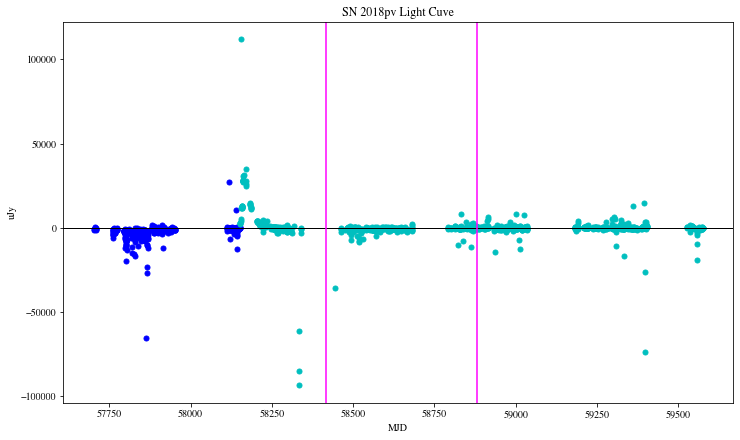

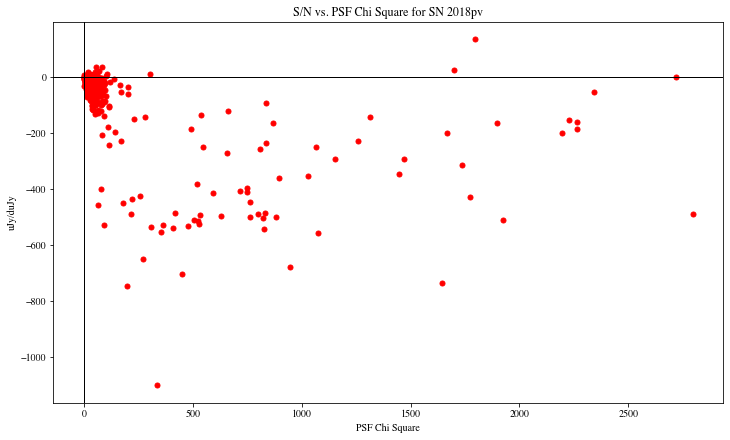

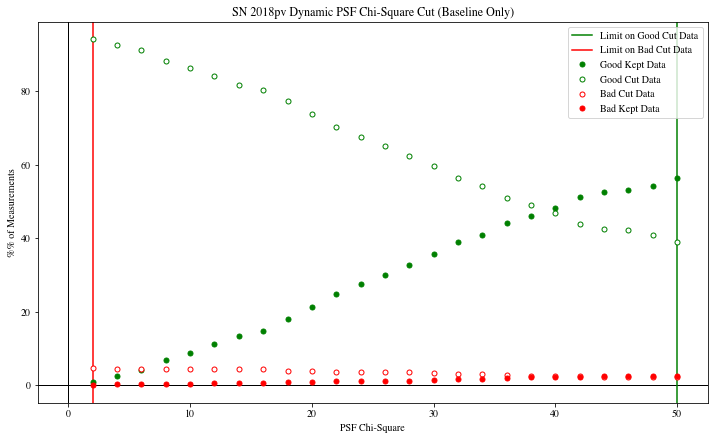

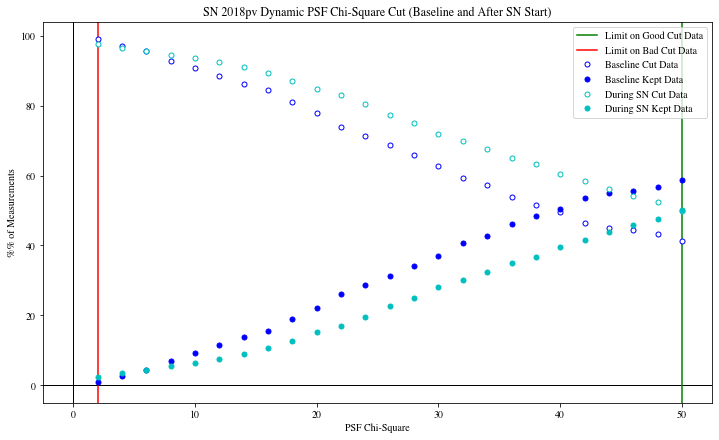

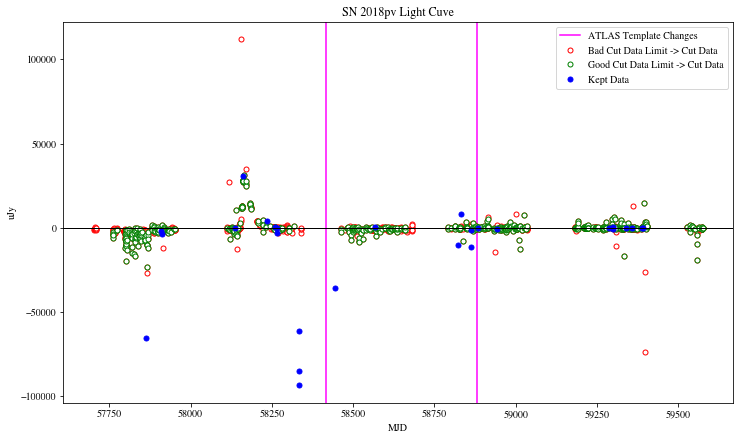

In [46]:
cases = ['2018pv']#['2018pv','2017guh','2018oh']
lc_info_cases_i = []
for sn in cases:
    lc_info_cases_i.append(np.where(lc_info.t['tnsname']==sn)[0][0])
lc_info_cases = lc_info.t.loc[lc_info_cases_i]
lc_info_cases = lc_info_cases.reset_index(drop=True)
print(lc_info_cases)

for index in range(0,len(lc_info_cases)):
    plot_lc(lc_dict[lc_info_cases.loc[index,'lc_dict key']], lc_info_cases.loc[index])
    
    plot_stn_chisquare(lc_dict[lc_info_cases.loc[index,'lc_dict key']], lc_info_cases.loc[index])
    
    info = get_plot_table(lc_dict[lc_info_cases.loc[index,'lc_dict key']], lc_info_cases.loc[index])
    lc_info.t.loc[index] = info
    print(lc_info.t.loc[index])
    
    plot_cut_lc(lc_dict[lc_info_cases.loc[index,'lc_dict key']], lc_info_cases.loc[index])

    regionstates_allsne = pdastrostatsclass(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])
    regionstates = get_region_table(lc_dict[lc_info_cases.loc[index,'lc_dict key']], lc_info_cases.loc[index])
    print('SN %s MJD region states w.r.t. PSF chi-square values:' % (lc_info_cases.loc[index,'tnsname'])) 
    print(regionstates.t,'\n')
    regionstates_allsne.t.loc[index,'tnsname'] = lc_info_cases.loc[index,'tnsname']
    regionstates_allsne.t.loc[index,'classification'] = lc_info_cases.loc[index,'classification']
    for i in range(0,len(regionstates.t['region'])):
        regionstates_allsne.t.loc[index,regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'state']
    regionstates_allsne.t.style.applymap(color)

In [49]:
# INDEX of the SN to represent out of the cases list above
interactive_lc_cases_i = 0

# INTERACTIVE CUT PLOT
global lcx 
lcx = lc_dict[lc_info_cases.loc[interactive_lc_cases_i,'lc_dict key']]
global infox
infox = lc_info_cases.loc[interactive_lc_cases_i]
interactive_plot = interactive(plot_cut_lc_simple_1,cut=(2,50,2))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=26, description='cut', max=50, min=2, step=2), Output(layout=Layout(heig…